# Libraries

In [1]:
#import relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Layer, Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Reshape, Conv2DTranspose, Embedding, UpSampling2D, concatenate, Multiply, Add, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import cv2

2022-10-28 13:32:47.052589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Loader, Writers

In [2]:
#Display some test images from the test set of tiny-imagenet
def display_formatted_image(data_loc, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    data = np.load(data_loc)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

#Display some test images from the test set of tiny-imagenet
def display_usps_image(data, num_row, num_col):
    #see few examples
    # plot images
    d_size = 0
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
    random_images = data[np.random.choice(data.shape[0], num_col*num_row)]
    for i in range(num_row*num_col):
        ax = axes[int(i/num_col), i%num_col]
        img = img_to_array(random_images[i])
        img = img.astype(int)
        
        d_size = img.shape
        ax.imshow(img)
        #ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()
    print("Image dimension in the dataset: ",d_size)

 $$\bf A. \space MNIST \space - \space USPS \space data$$

In [3]:
#numpy function
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    
def read_usps_dataset(filename):
    with h5py.File(filename, 'r') as hf:
        train = hf.get('train')
        X_tr = (255*train.get('data')[:]).astype('uint8')
        #data is of 16x16 shape
        X = []
        X2 = []
        X_tr = X_tr.reshape((X_tr.shape[0], 16, 16))
        #padding from 16 to 28 
        for i in range(X_tr.shape[0]):
            X.append(np.pad(X_tr[i], 6, pad_with, padder=0))
        X_tr = np.array(X)
        X_tr = np.expand_dims(X_tr, axis=3)
        y_tr = train.get('target')[:]
        test = hf.get('test')
        
        X_te = (255*test.get('data')[:]).astype('uint8')
        X_te = X_te.reshape((X_te.shape[0], 16, 16))
        #padding from 16 to 28
        for i in range(X_te.shape[0]):
            X2.append(np.pad(X_te[i], 6, pad_with, padder=0))
            
        X_te = np.array(X2)
        X_te = np.expand_dims(X_te, axis=3)
        y_te = test.get('target')[:]
        #make it 3 channel
        X_te = np.repeat(X_te, 3, axis=3)
        X_tr = np.repeat(X_tr, 3, axis=3)
    return X_tr, y_tr, X_te, y_te


X_train_usps, y_train_usps, X_test_usps, y_test_usps = read_usps_dataset("../MNIST_USPS/usps.h5")
print("USPS train dataset shape: X ={}, y={}".format(X_train_usps.shape, y_train_usps.shape))
print("USPS test dataset shape: X ={}, y={}".format(X_test_usps.shape, y_test_usps.shape))

USPS train dataset shape: X =(7291, 28, 28, 3), y=(7291,)
USPS test dataset shape: X =(2007, 28, 28, 3), y=(2007,)


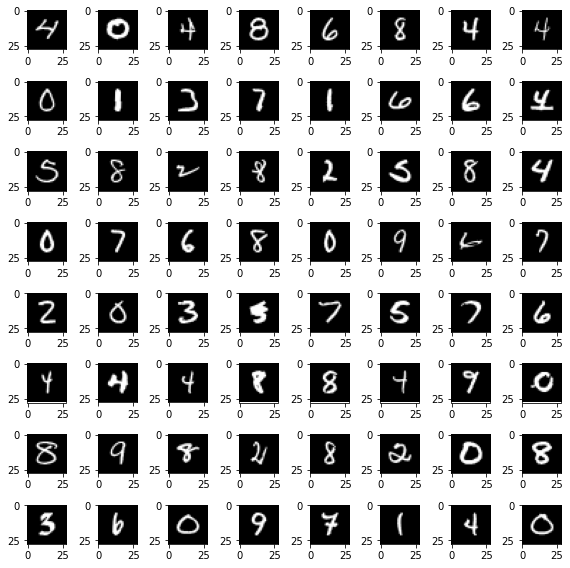

Image dimension in the dataset:  (28, 28, 3)
[0 1 2 3 4 5 6 7 8 9]


In [4]:
display_usps_image(X_test_usps, 8, 8)
print(np.unique(y_train_usps))

Mnist train dataset shape: X =(60000, 28, 28, 3), y=(60000,)
Mnist test dataset shape: X =(10000, 28, 28, 3), y=(10000,)


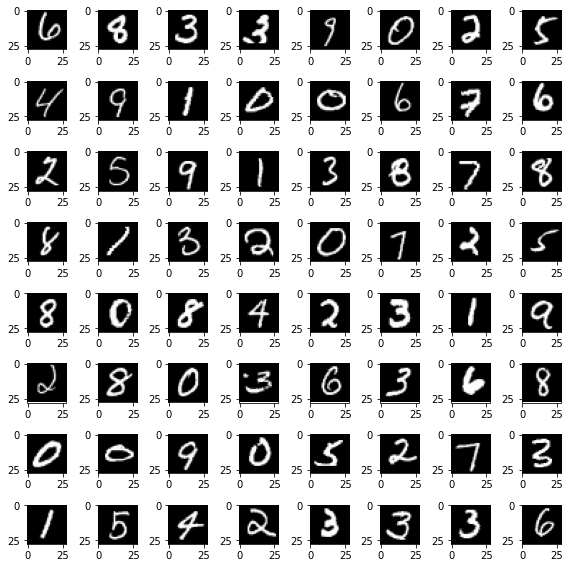

Image dimension in the dataset:  (28, 28, 3)
[0 1 2 3 4 5 6 7 8 9]


In [5]:
def read_mnist_dataset():
    (X_tr, y_tr), (X_te, y_te) = mnist.load_data()
    X_tr = np.expand_dims(X_tr, axis=3)
    X_tr = np.repeat(X_tr, 3, axis=3)
    X_te = np.expand_dims(X_te, axis=3)
    X_te = np.repeat(X_te, 3, axis=3)
    return X_tr.astype('uint8'), y_tr, X_te.astype('uint8'), y_te

X_train_mnist, y_train_mnist, X_test_mnist, y_test_mnist = read_mnist_dataset()
print("Mnist train dataset shape: X ={}, y={}".format(X_train_mnist.shape, y_train_mnist.shape))
print("Mnist test dataset shape: X ={}, y={}".format(X_test_mnist.shape, y_test_mnist.shape))
display_usps_image(X_train_mnist, 8, 8)
print(np.unique(y_train_mnist))

$$\bf B. \space ClipArt \space - \space Real \space (Office-Home) $$

Real World Data


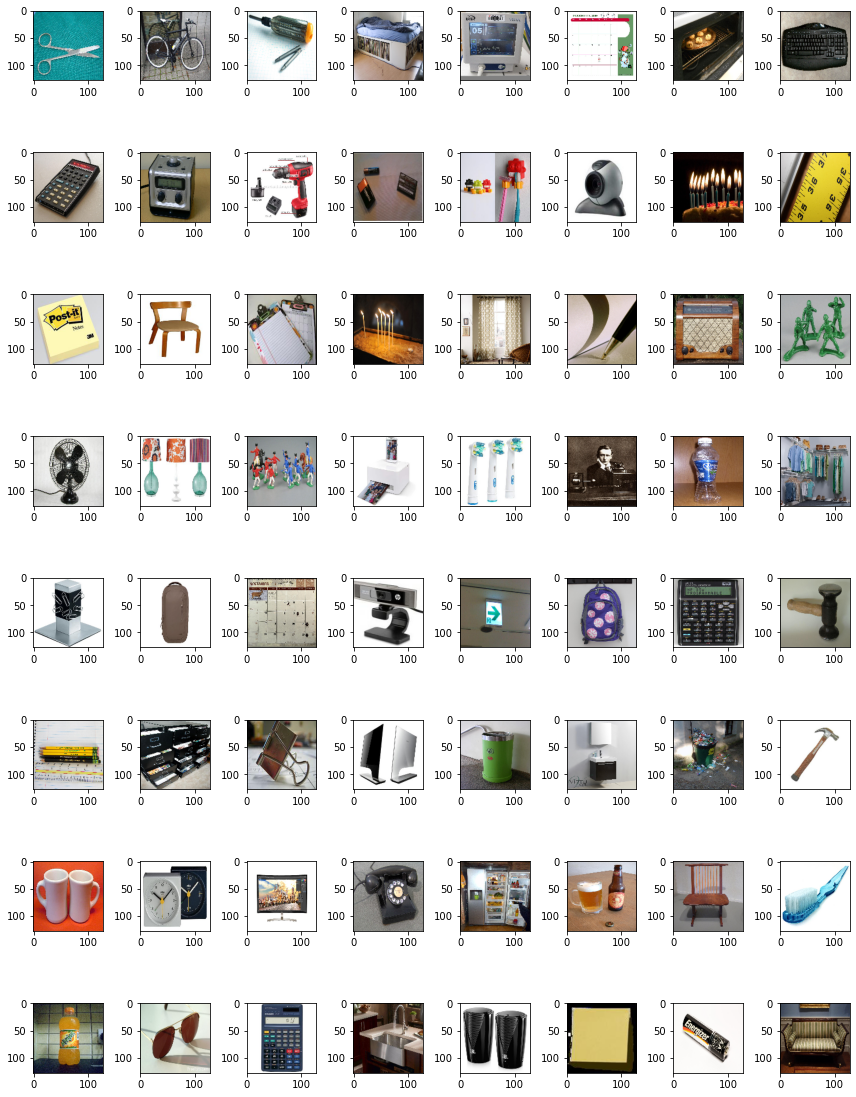

Image dimension in the dataset:  (128, 128, 3)
Clipart Data


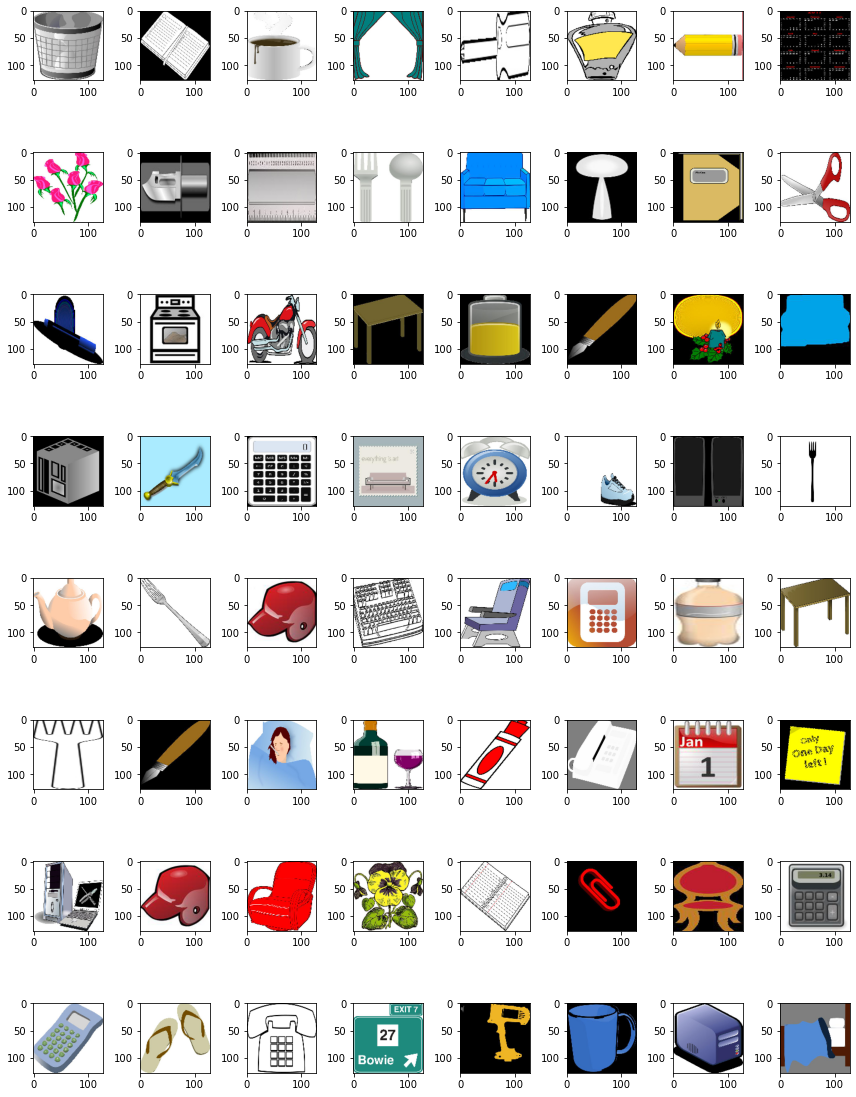

Image dimension in the dataset:  (128, 128, 3)


In [3]:
print("Real World Data")
display_formatted_image("../OfficeHomeDataset/Real World/train_X.npy", 8, 8)
print("Clipart Data")
display_formatted_image("../OfficeHomeDataset/Clipart/test_X.npy", 8, 8)

In [4]:
#load the real data 
X_train_real = np.load("../OfficeHomeDataset/Real World/train_X.npy") 
y_train_real = np.load("../OfficeHomeDataset/Real World/train_y.npy")
X_test_real = np.load("../OfficeHomeDataset/Real World/test_X.npy")
y_test_real = np.load("../OfficeHomeDataset/Real World/test_y.npy")
print("Real Data")
print("Train X size = {}, Train y size = {}".format(X_train_real.shape, y_train_real.shape))
print("Test X size = {}, Test y size = {}".format(X_test_real.shape, y_test_real.shape))
#load the clipart data
X_train_clip = np.load("../OfficeHomeDataset/Clipart/train_X.npy")
y_train_clip = np.load("../OfficeHomeDataset/Clipart/train_y.npy")
X_test_clip = np.load("../OfficeHomeDataset/Clipart/test_X.npy")
y_test_clip = np.load("../OfficeHomeDataset/Clipart/test_y.npy")
print("Clipart Data")
print("Train X size = {}, Train y size = {}".format(X_train_clip.shape, y_train_clip.shape))
print("Test X size = {}, Test y size = {}".format(X_test_clip.shape, y_test_clip.shape))

Real Data
Train X size = (3511, 128, 128, 3), Train y size = (3511,)
Test X size = (846, 128, 128, 3), Test y size = (846,)
Clipart Data
Train X size = (3519, 128, 128, 3), Train y size = (3519,)
Test X size = (846, 128, 128, 3), Test y size = (846,)


# Model

In [5]:
#define a gradient reversal layer
#buiding a custom layer
#using tf.custom_gradient: https://www.tensorflow.org/guide/basics#custom_gradients: clearly mentioned in docu.

class GradReversal_layer(Layer):
    def __init__(self, name, l):
        super().__init__(name=name)
        self.m = l
        
    @tf.custom_gradient
    def reverse_gradients(self, inp):
        #forward propagation
        out = tf.identity(inp)
        #gradient reversal definiton
        def grad(out_grad):
            return -1*self.m*out_grad
        
        return out, grad
    
    def call(self, inp):
        return self.reverse_gradients(inp)
    
class Model_Resnet_DAN(object):
    def __init__(self, input_shape, num_classes, bs=128, l=0.1):
        #make the Resnet 
        self.arch_hyperparameters =  { 'lr': 0.001, 
                                       'lambda': l,
                                       'batch_size': bs 
                                     }
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_feat_extractor_label = None
        self.model_feat_extractor_domain = None
        self.model_label = None
        self.model_domain = None
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.arch_hyperparameters['lr'])
        
    def get_fc_functional(self, inp, layer1_neurons, final_neurons, act, grad_rev=False, intermediate_layer=False):
        if intermediate_layer==True:
            t = GlobalAveragePooling2D(name='flatten_intermediate')(inp)
            if grad_rev == True:
                t = GradReversal_layer(name='Gradient_Rev', l=self.arch_hyperparameters['lambda'])(t)
        else:
            if grad_rev == True:
                t = GradReversal_layer(name='Gradient_Rev', l=self.arch_hyperparameters['lambda'])(inp)
            else:
                t = inp
        t = Dense(layer1_neurons, activation='relu')(t)
        t = Dense(final_neurons, activation=act)(t)
        
        return t
    
    
    def make_DAN_Resnet(self, reversal_layer_name, intermediate_layer=False, weights_init=None):
        inp = Input([None, None, 3], dtype = tf.float32, name='Resnet_input')
        prep_inp = preprocess_input(inp)
        
        
        #we are using the include top layer to true: let the model have 1000 classes, anyways we are making our own classifier layer
        #so keeping it 1000 would not be a problem
        rnet50 = ResNet50(include_top=True, weights=weights_init, input_tensor=prep_inp, 
                          input_shape=None, pooling=None, classes=1000)
        
        
        feat_ext_layer_out_domain = rnet50.get_layer(reversal_layer_name).output
        
        feat_ext_layer_out_label = rnet50.get_layer('avg_pool').output
        #this is the middle layer of resnet for extracting features
        #feature extractor network
        self.model_feat_extractor_domain = Model(inputs=rnet50.inputs, outputs=feat_ext_layer_out_domain, name='feature_extractor_domain')
        self.model_feat_extractor_label = Model(inputs=rnet50.inputs, outputs=feat_ext_layer_out_label, name='feature_extractor_label')
        #extract the features
        out_feat_extr_label = self.model_feat_extractor_label(prep_inp)
        out_feat_extr_domain = self.model_feat_extractor_domain(prep_inp)
        #use this to predict the label, never an intermediate layer
        label_pred = self.get_fc_functional(out_feat_extr_label, min(10*self.num_classes, 256), self.num_classes, 'softmax', False, False)
        self.model_label = Model(inputs=self.model_feat_extractor_label.input, outputs=label_pred, name='label_predictor')
        
        
        #the reversal layer addition: getting the required layer output 
        domain_pred = self.get_fc_functional(out_feat_extr_domain, 64, 1, 'sigmoid', True, intermediate_layer)
        self.model_domain = Model(inputs=self.model_feat_extractor_domain.input, outputs=domain_pred, name='domain_predictor')
        
        self.model_feat_extractor_domain.compile()
        self.model_feat_extractor_label.compile()
        self.model_label.compile(metrics=['accuracy'])
        self.model_domain.compile(metrics=['accuracy'])
        self.model_feat_extractor_label.summary()
        self.model_feat_extractor_domain.summary()
        self.model_label.summary()
        self.model_domain.summary()
        
        #self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    
    def track_losses(self, batch_X_source, batch_y_source, batch_X_target):
        
        X_domain = np.concatenate([batch_X_source, batch_X_target], axis=0)
        
        #take the source as 1, and the target as 0
        y_domain = np.concatenate([np.ones(batch_X_source.shape[0]), np.zeros(batch_X_target.shape[0])])
        
        #shuffler = np.arange(batch_X_source.shape[0]+batch_X_target.shape[0])
        #np.random.shuffle(shuffler)
        
        #shuffles the domain examples
        #X_domain = X_domain[shuffler]
        
        #y_domain = y_domain[shuffler]
        
        #the label training
        #shuffler2 = np.arange(batch_X_source.shape[0])
        #np.random.shuffle(shuffler2)
        #batch_X_source = batch_X_source[shuffler2]
        #batch_y_source = batch_y_source[shuffler2]
        
        pred_class = self.model_label(batch_X_source)
        loss_classification = CategoricalCrossentropy()(tf.one_hot(batch_y_source, self.num_classes), pred_class)
        acc_class = tf.keras.metrics.Accuracy()(batch_y_source, tf.argmax(pred_class, axis=1))
        #domain loss
        pred_domain = self.model_domain(X_domain)
        acc_domain = tf.keras.metrics.Accuracy()(y_domain, (pred_domain>0.5))
        #loss of the label
        loss_domain = BinaryCrossentropy()(y_domain, tf.squeeze(pred_domain))
        
        return loss_classification.numpy(), acc_class.numpy(), loss_domain.numpy(), acc_domain.numpy()
        
    def back_prop_DAN(self, batch_X_source, batch_y_source, batch_X_target):
        X_domain = np.concatenate([batch_X_source, batch_X_target], axis=0)
        #take the source as 1, and the target as 0
        y_domain = np.concatenate([np.ones(batch_X_source.shape[0]), np.zeros(batch_X_target.shape[0])])
        
        #shuffler = np.arange(batch_X_source.shape[0]+batch_X_target.shape[0])
        #np.random.shuffle(shuffler)
        #shuffles the domain examples
        #X_domain = X_domain[shuffler]
        #y_domain = y_domain[shuffler]
        
        #the label training
        #shuffler2 = np.arange(batch_X_source.shape[0])
        #np.random.shuffle(shuffler2)
        #batch_X_source = batch_X_source[shuffler2]
        #batch_y_source = batch_y_source[shuffler2]
        
        with tf.GradientTape(persistent=True) as tape:
            #classification loss
            pred_class = self.model_label(batch_X_source)
            loss_classification = CategoricalCrossentropy()(tf.one_hot(batch_y_source, self.num_classes), pred_class)
            
            #domain loss
            pred_domain = self.model_domain(X_domain)
            #loss of the label
            loss_domain = BinaryCrossentropy()(y_domain, tf.squeeze(pred_domain))
        
        #update the classifier gradients
        grad_class = tape.gradient(loss_classification, self.model_label.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_class, self.model_label.trainable_variables))
        #update the domain gradients
        grad_domain = tape.gradient(loss_domain, self.model_domain.trainable_variables)
        self.optimizer.apply_gradients(zip(grad_domain, self.model_domain.trainable_variables))
        
    def train_RESNET_DAN(self, train_X_source, train_y_source, train_X_target, n_epochs=5):
        loss_history = {'loss_class': [],
                        'loss_domain': []
                       }
        acc_history = {'acc_domain': [],
                       'acc_class': [], 
                       }
        
        
        ep_length = int(np.ceil(train_X_source.shape[0]/self.arch_hyperparameters['batch_size']))
        for i in range(n_epochs):
            ch = np.random.choice(train_X_source.shape[0], self.arch_hyperparameters['batch_size'], replace=False)
            batch_source_X =  train_X_source[ch]
            batch_source_y = train_y_source[ch]
            batch_target = train_X_target[np.random.choice(train_X_target.shape[0], self.arch_hyperparameters['batch_size'], replace=False)]
            
            loss_class, acc_class, loss_domain, acc_domain = self.track_losses(batch_source_X, batch_source_y, batch_target)
            
            
            loss_history['loss_class'].append(loss_class)
            loss_history['loss_domain'].append(loss_domain)
            
            acc_history['acc_domain'].append(acc_domain)
            acc_history['acc_class'].append(acc_class)
            
            if i%2 == 0:
                print("Losses at epoch {},classification: {} domain: {}, train Accuracies: classification: {} domain: {}".format(i, loss_class, loss_domain, acc_class, acc_domain))
            
            #shuffle the data
            shuffler = np.arange(train_X_source.shape[0])
            np.random.shuffle(shuffler)
            
            train_X_source =  train_X_source[shuffler]
            train_y_source = train_y_source[shuffler]
            
            for j in range(ep_length):
                
                batch_target = train_X_target[np.random.choice(train_X_target.shape[0], self.arch_hyperparameters['batch_size'], replace=False)]
                #batch_fake = self.generate_image(self.arch_hyperparameters['batch_size'])
                if j == ep_length - 1:
                    batch_source_X = train_X_source[j*self.arch_hyperparameters['batch_size']:train_X_source.shape[0]]
                    batch_source_y = train_y_source[j*self.arch_hyperparameters['batch_size']:train_X_source.shape[0]]
                else:
                    batch_source_X = train_X_source[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                    batch_source_y = train_y_source[j*(self.arch_hyperparameters['batch_size']):(j+1)*(self.arch_hyperparameters['batch_size'])]
                
                self.back_prop_DAN(batch_source_X, batch_source_y, batch_target)
        
        return loss_history, acc_history
        
    def test_cross_generalization(self, test_X, test_y):
        
        results = self.model_label.evaluate(test_X, tf.one_hot(test_y, self.num_classes))
        return results

In [47]:
my_model = Model_Resnet_DAN((28, 28, 3), 10)
my_model.make_DAN_Resnet('conv3_block1_out', True)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_9 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_9[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_9[0][0]           
____________________________________________________________________________

# Experiments and Results

In [21]:
#inspired from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
#plotter
def plot_accuracies_3group(train_acc, test_acc, cross_acc, baseline, labels, legends, __title__):
    
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    rects1 = ax.bar(x - width, train_acc, width, label=legends[0])
    rects2 = ax.bar(x, test_acc, width, label=legends[1])
    rects3 = ax.bar(x + width, cross_acc, width, label=legends[2])
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy', fontsize=20)
    ax.set_title(__title__, fontsize=25)
    ax.set_xticks(x, labels, fontsize=20)
    ax.axhline(y = baseline, color='black', linestyle = '--')
    
    ax.legend(fontsize=20)
    
    ax.bar_label(rects1, fontsize=20, padding=3)
    ax.bar_label(rects2, fontsize=20, padding=3)
    ax.bar_label(rects3, fontsize=20, padding=3)
    
    fig.tight_layout()

    plt.show()

$\bf \text{1. Applying gradient reversal at the End layer: 'avg_pool' layer}$

$$MNIST \to USPS $$

In [14]:
my_model_mnist = Model_Resnet_DAN((28, 28, 3), 10)
my_model_mnist.make_DAN_Resnet('avg_pool')
my_model_mnist.train_RESNET_DAN(X_train_mnist, y_train_mnist, X_train_usps)

Model: "feature_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_3[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_3[0][0]           
__________________________________________________________________________________

Losses at epoch 0,classification: 16.900558471679688 domain: 0.43037471175193787, train Accuracies: classification: 0.1015625 domain: 0.5
Losses at epoch 2,classification: 0.07453937828540802 domain: 0.06931474059820175, train Accuracies: classification: 0.984375 domain: 0.5
Losses at epoch 4,classification: 0.4212348759174347 domain: 0.06968235969543457, train Accuracies: classification: 0.8828125 domain: 0.51171875


({'loss_class': [16.900558, 0.15360925, 0.07453938, 0.14182383, 0.42123488],
  'loss_domain': [0.4303747, 0.069316156, 0.06931474, 0.06925597, 0.06968236]},
 {'acc_domain': [0.5, 0.5, 0.5, 0.48828125, 0.51171875],
  'acc_class': [0.1015625, 0.96875, 0.984375, 0.9453125, 0.8828125]})

In [15]:
accuracy_self_mnist = my_model_mnist.test_cross_generalization(X_test_mnist, y_test_mnist)
accuracy_cross_usps = my_model_mnist.test_cross_generalization(X_test_usps, y_test_usps)

2022-10-27 20:11:13.932020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-27 20:11:13.951266: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2597015000 Hz


63/63 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 0.9018


$$USPS \to MNIST$$

In [16]:
my_model_usps = Model_Resnet_DAN((28, 28, 3), 10)
my_model_usps.make_DAN_Resnet('avg_pool')
my_model_usps.train_RESNET_DAN(X_train_usps, y_train_usps, X_train_mnist)

Model: "feature_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_4[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_4[0][0]           
__________________________________________________________________________________

Losses at epoch 0,classification: 7.988170146942139 domain: 0.39983856678009033, train Accuracies: classification: 0.140625 domain: 0.5
Losses at epoch 2,classification: 0.13906320929527283 domain: 0.06932001560926437, train Accuracies: classification: 0.9609375 domain: 0.5
Losses at epoch 4,classification: 0.026252657175064087 domain: 0.06931795179843903, train Accuracies: classification: 1.0 domain: 0.5


({'loss_class': [7.98817, 0.7955059, 0.13906321, 0.20150237, 0.026252657],
  'loss_domain': [0.39983857, 0.07239889, 0.069320016, 0.0693191, 0.06931795]},
 {'acc_domain': [0.5, 0.453125, 0.5, 0.5, 0.5],
  'acc_class': [0.140625, 0.6953125, 0.9609375, 0.9375, 1.0]})

In [18]:
accuracy_self_usps = my_model_usps.test_cross_generalization(X_test_usps, y_test_usps)
accuracy_cross_mnsit = my_model_usps.test_cross_generalization(X_test_mnist, y_test_mnist)

313/313 [==============================] - 3s 11ms/step - loss: 0.0000e+00 - accuracy: 0.7968


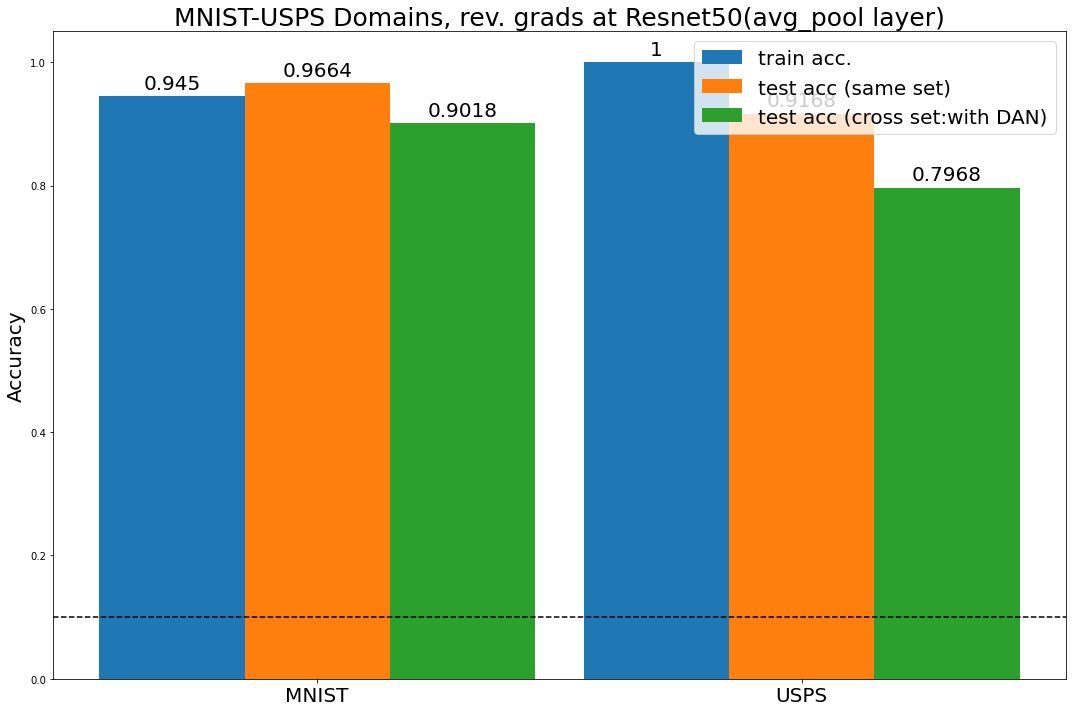

In [26]:
plot_accuracies_3group([0.945, 1.0], [0.9664, 0.9168], [0.9018, 0.7968], 0.1, ['MNIST', 'USPS'], ['train acc.', 'test acc (same set)', 'test acc (cross set:with DAN)'], "MNIST-USPS Domains, rev. grads at Resnet50(avg_pool layer)")

$$Clipart \to Real World$$

In [6]:
#number of unique labels is 65, 64 batch size and, last input is the lambda for DAN
my_model_clip = Model_Resnet_DAN((128, 128, 3), 65, 64, 0.1)
my_model_clip.make_DAN_Resnet('avg_pool', False, None)
my_model_clip.train_RESNET_DAN(X_train_clip, y_train_clip, X_train_real, 40)

2022-10-28 13:33:48.909440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-28 13:33:48.910360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-28 13:33:48.963717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-10-28 13:33:48.964124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-10-28 13:33:48.964144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.s

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, None, None, 3 0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add[0][0]             
____________________________________________________________________________

2022-10-28 13:33:51.189238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-28 13:33:51.629446: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-10-28 13:33:51.674088: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-28 13:33:52.009951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Losses at epoch 0,classification: 19.216594696044922 domain: 6.905618667602539, train Accuracies: classification: 0.0 domain: 0.5
Losses at epoch 2,classification: 4.116106033325195 domain: 0.6624525189399719, train Accuracies: classification: 0.0 domain: 0.6484375
Losses at epoch 4,classification: 3.960226535797119 domain: 0.6703119874000549, train Accuracies: classification: 0.0625 domain: 0.515625
Losses at epoch 6,classification: 3.6693787574768066 domain: 0.6408161520957947, train Accuracies: classification: 0.046875 domain: 0.6640625
Losses at epoch 8,classification: 3.4085073471069336 domain: 0.6166260242462158, train Accuracies: classification: 0.171875 domain: 0.6640625
Losses at epoch 10,classification: 2.435588836669922 domain: 0.5797290205955505, train Accuracies: classification: 0.4375 domain: 0.71875
Losses at epoch 12,classification: 1.1953102350234985 domain: 0.5077679753303528, train Accuracies: classification: 0.703125 domain: 0.734375
Losses at epoch 14,classificatio

({'loss_class': [19.216595,
   4.121389,
   4.116106,
   4.1111913,
   3.9602265,
   3.8229408,
   3.6693788,
   3.4518929,
   3.4085073,
   2.8479548,
   2.4355888,
   2.1140885,
   1.1953102,
   0.89469504,
   1.2110169,
   0.74171746,
   0.5273922,
   0.65971303,
   0.39311674,
   0.30724502,
   0.3387409,
   0.18585089,
   0.19532399,
   0.18623716,
   0.18460944,
   0.09216173,
   0.33448288,
   0.2181426,
   0.16533811,
   0.2753415,
   0.13662088,
   0.17813747,
   0.25259042,
   0.3214226,
   0.15452966,
   0.092834465,
   0.08478992,
   0.07283558,
   0.55692333,
   0.04890454],
  'loss_domain': [6.9056187,
   0.6754371,
   0.6624525,
   0.6973737,
   0.670312,
   0.6488174,
   0.64081615,
   0.6332257,
   0.616626,
   0.5973613,
   0.579729,
   0.59957343,
   0.507768,
   0.6032843,
   0.50245965,
   0.5269592,
   0.43144673,
   0.501467,
   0.47266084,
   0.5551834,
   0.5422233,
   0.45821512,
   0.4657775,
   0.5475785,
   0.5061926,
   0.40904602,
   0.5041731,
   0.62890

In [7]:
accuracy_self_clip = my_model_clip.test_cross_generalization(X_test_clip, y_test_clip)
accuracy_cross_real = my_model_clip.test_cross_generalization(X_test_real, y_test_real)

2022-10-28 13:49:28.481467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-28 13:49:28.498806: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492975000 Hz


27/27 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0461


In [8]:
del my_model_clip

$$Real World \to Clipart$$

In [9]:
#number of unique labels is 65
my_model_real = Model_Resnet_DAN((128, 128, 3), 65, 64)
my_model_real.make_DAN_Resnet('avg_pool', False, None)
my_model_real.train_RESNET_DAN(X_train_real, y_train_real, X_train_clip, 40)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_1[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_1[0][0]           
____________________________________________________________________________

Losses at epoch 2,classification: 4.1560258865356445 domain: 0.7244657278060913, train Accuracies: classification: 0.046875 domain: 0.5
Losses at epoch 4,classification: 3.9519991874694824 domain: 0.66324383020401, train Accuracies: classification: 0.0625 domain: 0.5390625
Losses at epoch 6,classification: 4.007930755615234 domain: 0.622456967830658, train Accuracies: classification: 0.0625 domain: 0.6875
Losses at epoch 8,classification: 3.6385440826416016 domain: 0.5838315486907959, train Accuracies: classification: 0.09375 domain: 0.671875
Losses at epoch 10,classification: 3.2432961463928223 domain: 0.6247100830078125, train Accuracies: classification: 0.203125 domain: 0.65625
Losses at epoch 12,classification: 3.0487565994262695 domain: 0.5970666408538818, train Accuracies: classification: 0.234375 domain: 0.734375
Losses at epoch 14,classification: 2.624847173690796 domain: 0.5718396902084351, train Accuracies: classification: 0.328125 domain: 0.7578125
Losses at epoch 16,classif

({'loss_class': [23.725113,
   4.099487,
   4.156026,
   3.9433599,
   3.9519992,
   3.8068602,
   4.0079308,
   3.655716,
   3.638544,
   3.5889506,
   3.2432961,
   3.1842208,
   3.0487566,
   2.5701227,
   2.6248472,
   2.2769084,
   2.3366897,
   1.5415583,
   1.4424984,
   1.5527302,
   1.0553365,
   0.61512494,
   0.9622277,
   0.58477944,
   0.51918447,
   0.24209473,
   0.35085127,
   0.2645893,
   0.29287845,
   0.11505835,
   0.11647263,
   0.1158373,
   0.13064712,
   0.22247186,
   0.11492641,
   0.6602676,
   0.08688884,
   0.13316724,
   0.041543648,
   0.39611042],
  'loss_domain': [0.9787229,
   1.210965,
   0.7244657,
   0.66002846,
   0.66324383,
   0.63626564,
   0.62245697,
   0.58448267,
   0.58383155,
   0.6026758,
   0.6247101,
   0.5537814,
   0.59706664,
   0.54188067,
   0.5718397,
   0.56788445,
   0.6036781,
   0.61651593,
   0.74865985,
   0.5579039,
   0.55378973,
   0.48835042,
   0.53054655,
   0.5537185,
   0.5424227,
   0.55126816,
   0.55789953,
   0.

In [10]:
accuracy_self_real = my_model_real.test_cross_generalization(X_test_real, y_test_real)
accuracy_cross_clip = my_model_real.test_cross_generalization(X_test_clip, y_test_clip)

27/27 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0674


In [11]:
del my_model_real

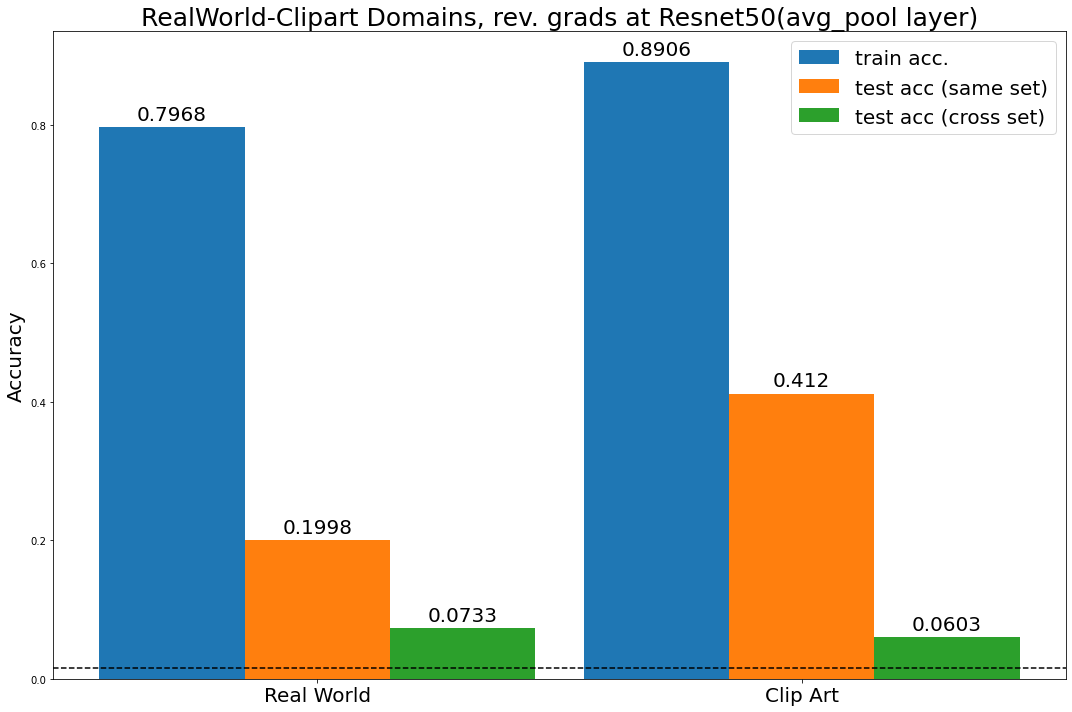

In [27]:
#plot details
plot_accuracies_3group([0.7968, 0.8906], [0.1998, 0.412], [0.0733, 0.0603], 0.01538, ['Real World', 'Clip Art'], ['train acc.', 'test acc (same set)', 'test acc (cross set)'], "RealWorld-Clipart Domains, rev. grads at Resnet50(avg_pool layer)")

$\bf \text{2. Applying gradient reversal at the Intermediate layer 1: ''conv3_block1_out' layer}$

$$MNIST \to USPS $$

In [61]:
my_model_mnist = Model_Resnet_DAN((28, 28, 3), 10)
my_model_mnist.make_DAN_Resnet('conv3_block1_out', True)
my_model_mnist.train_RESNET_DAN(X_train_mnist, y_train_mnist, X_train_usps)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_26 (Sl (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_26 (TFOpLambda)  (None, None, None, 3 0           tf.__operators__.getitem_26[0][0]
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_26[0][0]          
____________________________________________________________________________

Losses at epoch 0,classification: 9.7891845703125 domain: 1.5388027429580688, train Accuracies: classification: 0.078125 domain: 0.5
Losses at epoch 2,classification: 0.02434982918202877 domain: 7.712474346160889, train Accuracies: classification: 0.9921875 domain: 0.5
Losses at epoch 4,classification: 0.012598983943462372 domain: 7.712474346160889, train Accuracies: classification: 1.0 domain: 0.5


({'loss_class': [9.789185, 0.16592555, 0.02434983, 0.03145206, 0.012598984],
  'loss_domain': [1.5388027, 7.7124743, 7.7124743, 7.7124743, 7.7124743]},
 {'acc_domain': [0.5, 0.5, 0.5, 0.5, 0.5],
  'acc_class': [0.078125, 0.9609375, 0.9921875, 0.9921875, 1.0]})

In [63]:
accuracy_self_mnist = my_model_mnist.test_cross_generalization(X_test_mnist, y_test_mnist)
accuracy_cross_usps = my_model_mnist.test_cross_generalization(X_test_usps, y_test_usps)

63/63 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8974


$$USPS \to MNIST$$

In [67]:
my_model_usps = Model_Resnet_DAN((28, 28, 3), 10)
my_model_usps.make_DAN_Resnet('conv3_block1_out', True)
my_model_usps.train_RESNET_DAN(X_train_usps, y_train_usps, X_train_mnist, 20)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_28 (Sl (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_28 (TFOpLambda)  (None, None, None, 3 0           tf.__operators__.getitem_28[0][0]
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_28[0][0]          
____________________________________________________________________________

Losses at epoch 2,classification: 0.37405264377593994 domain: 7.666619300842285, train Accuracies: classification: 0.8984375 domain: 0.5
Losses at epoch 4,classification: 0.10360439121723175 domain: 7.666619300842285, train Accuracies: classification: 0.9609375 domain: 0.5
Losses at epoch 6,classification: 0.006947116926312447 domain: 7.666619300842285, train Accuracies: classification: 1.0 domain: 0.5
Losses at epoch 8,classification: 0.05293385684490204 domain: 7.666619300842285, train Accuracies: classification: 0.9921875 domain: 0.5
Losses at epoch 10,classification: 0.020673517137765884 domain: 7.666619300842285, train Accuracies: classification: 0.984375 domain: 0.5
Losses at epoch 12,classification: 0.0618676096200943 domain: 7.666619300842285, train Accuracies: classification: 0.9765625 domain: 0.5
Losses at epoch 14,classification: 0.028934627771377563 domain: 7.666619300842285, train Accuracies: classification: 0.9921875 domain: 0.5
Losses at epoch 16,classification: 0.195114

({'loss_class': [14.322449,
   1.8570089,
   0.37405264,
   0.17743178,
   0.10360439,
   0.07815754,
   0.006947117,
   0.0313132,
   0.052933857,
   0.049057677,
   0.020673517,
   0.019998103,
   0.06186761,
   0.018445583,
   0.028934628,
   1.9900643,
   0.19511455,
   0.12484206,
   0.003708171,
   0.037288364],
  'loss_domain': [7.7124743,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743]},
 {'acc_domain': [0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5],
  'acc_class': [0.1015625,
   0.359375,
   0.8984375,
   0.953125,
   0.9609375,
   0.9765625,
   1.0,
   0.9921875,
   0.9921875,
   0.9921875,
   0.984375,
   0.9921875,
   0.9765625,
   0.9921875,
   0.992

In [68]:
accuracy_self_usps = my_model_usps.test_cross_generalization(X_test_usps, y_test_usps)
accuracy_cross_mnsit = my_model_usps.test_cross_generalization(X_test_mnist, y_test_mnist)

313/313 [==============================] - 3s 11ms/step - loss: 0.0000e+00 - accuracy: 0.8724


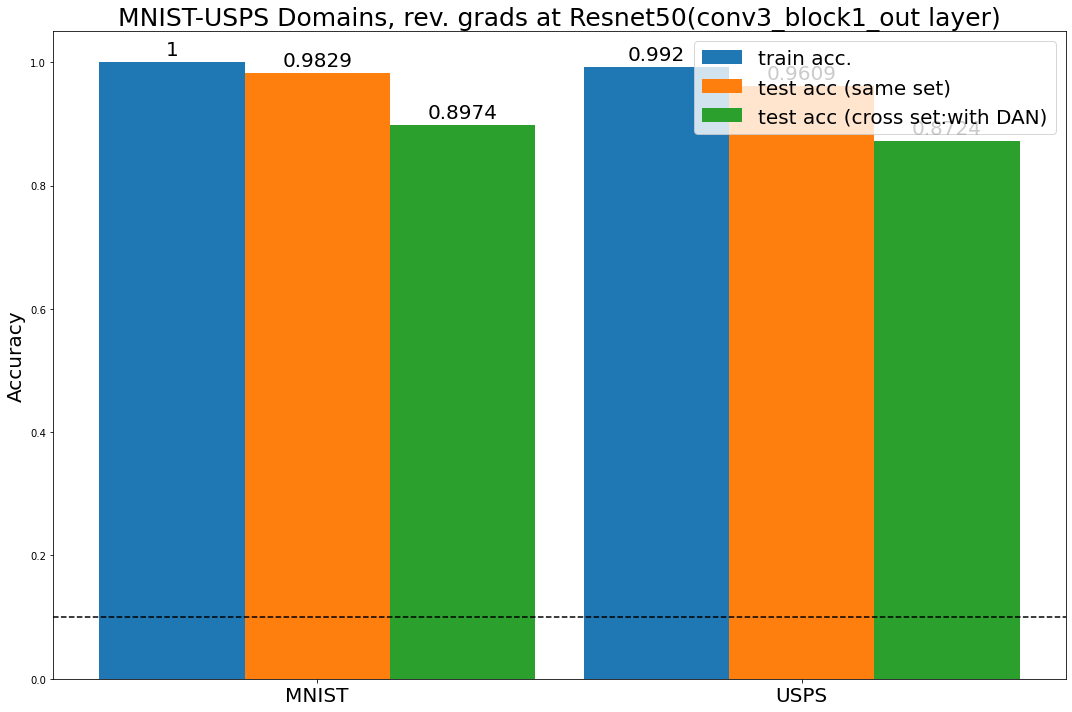

In [28]:
plot_accuracies_3group([1.0, 0.992], [0.9829, 0.9609], [0.8974, 0.8724], 0.1, ['MNIST', 'USPS'], ['train acc.', 'test acc (same set)', 'test acc (cross set:with DAN)'], "MNIST-USPS Domains, rev. grads at Resnet50(conv3_block1_out layer)")

$$Clipart \to Real World$$

In [12]:
#number of unique labels is 65, 64 batch size and, last input is the lambda for DAN
my_model_clip = Model_Resnet_DAN((128, 128, 3), 65, 64, 0.1)
my_model_clip.make_DAN_Resnet('conv3_block1_out', True, 'imagenet')
my_model_clip.train_RESNET_DAN(X_train_clip, y_train_clip, X_train_real, 40)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_2[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_2[0][0]           
____________________________________________________________________________

Losses at epoch 2,classification: 4.156123638153076 domain: 7.666619300842285, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 4,classification: 4.13430118560791 domain: 7.666619300842285, train Accuracies: classification: 0.015625 domain: 0.5
Losses at epoch 6,classification: 4.1015305519104 domain: 7.666619300842285, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 8,classification: 4.148856163024902 domain: 7.666619300842285, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 10,classification: 4.095370292663574 domain: 7.666619300842285, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 12,classification: 4.062735557556152 domain: 7.666619300842285, train Accuracies: classification: 0.015625 domain: 0.5
Losses at epoch 14,classification: 4.124881267547607 domain: 7.712474346160889, train Accuracies: classification: 0.046875 domain: 0.5
Losses at epoch 16,classification: 4.177257537841797 domain: 0.699

({'loss_class': [5.6591806,
   4.114924,
   4.1561236,
   4.089282,
   4.134301,
   4.1301603,
   4.1015306,
   4.098546,
   4.148856,
   4.091588,
   4.0953703,
   4.1053557,
   4.0627356,
   4.053487,
   4.1248813,
   4.75159,
   4.1772575,
   4.158752,
   4.1497846,
   4.151325,
   4.1131716,
   4.131283,
   4.1388054,
   4.1299305,
   4.1541147,
   4.129796,
   4.1066675,
   4.102986,
   4.1303873,
   4.1219807,
   4.1206384,
   4.143651,
   4.134042,
   4.154892,
   4.151975,
   4.0931244,
   4.1380587,
   4.097732,
   4.1456966,
   4.0632668],
  'loss_domain': [1.6073757,
   1.9949638,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.7124743,
   1.9307308,
   0.69977456,
   1.4886823,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.712

In [13]:
accuracy_self_clip = my_model_clip.test_cross_generalization(X_test_clip, y_test_clip)
accuracy_cross_real = my_model_clip.test_cross_generalization(X_test_real, y_test_real)

27/27 [==============================] - 1s 23ms/step - loss: 0.0000e+00 - accuracy: 0.0118


In [14]:
del my_model_clip

$$Real World \to Clipart$$

In [15]:
#number of unique labels is 65
my_model_real = Model_Resnet_DAN((128, 128, 3), 65, 64, l=0.01)
my_model_real.make_DAN_Resnet('conv3_block1_out', True, 'imagenet')
my_model_real.train_RESNET_DAN(X_train_real, y_train_real, X_train_clip, 40)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_3 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_3 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_3[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_3[0][0]           
____________________________________________________________________________

Losses at epoch 2,classification: 4.228979110717773 domain: 0.6259196996688843, train Accuracies: classification: 0.015625 domain: 0.65625
Losses at epoch 4,classification: 4.1686224937438965 domain: 7.384847640991211, train Accuracies: classification: 0.0 domain: 0.5
Losses at epoch 6,classification: 4.138348579406738 domain: 7.294626235961914, train Accuracies: classification: 0.046875 domain: 0.5
Losses at epoch 8,classification: 4.18118953704834 domain: 7.712474346160889, train Accuracies: classification: 0.0 domain: 0.5
Losses at epoch 10,classification: 4.14450740814209 domain: 7.712474346160889, train Accuracies: classification: 0.015625 domain: 0.5
Losses at epoch 12,classification: 4.136588096618652 domain: 7.711101531982422, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 14,classification: 4.216041088104248 domain: 7.71202278137207, train Accuracies: classification: 0.015625 domain: 0.5
Losses at epoch 16,classification: 4.103447437286377 domain: 0.9444

({'loss_class': [5.8574963,
   4.170948,
   4.228979,
   4.118203,
   4.1686225,
   4.152778,
   4.1383486,
   4.160356,
   4.1811895,
   4.106498,
   4.1445074,
   4.149164,
   4.136588,
   4.157317,
   4.216041,
   4.143732,
   4.1034474,
   4.1630554,
   4.1632705,
   4.1723404,
   4.1631093,
   4.168773,
   4.1763372,
   4.142105,
   4.1829376,
   4.146092,
   4.1576495,
   4.202797,
   4.166945,
   4.179984,
   4.1616364,
   4.1631393,
   4.1352177,
   4.1360855,
   4.1571107,
   4.1351995,
   4.1207633,
   4.132139,
   4.1273184,
   4.1659145],
  'loss_domain': [0.8218579,
   0.70135933,
   0.6259197,
   0.67650455,
   7.3848476,
   2.1639714,
   7.294626,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7111015,
   7.7124743,
   7.712023,
   7.7099986,
   0.9444709,
   1.1484007,
   7.607832,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666

In [16]:
accuracy_self_real = my_model_real.test_cross_generalization(X_test_real, y_test_real)
accuracy_cross_clip = my_model_real.test_cross_generalization(X_test_clip, y_test_clip)

27/27 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0130


In [17]:
del my_model_real

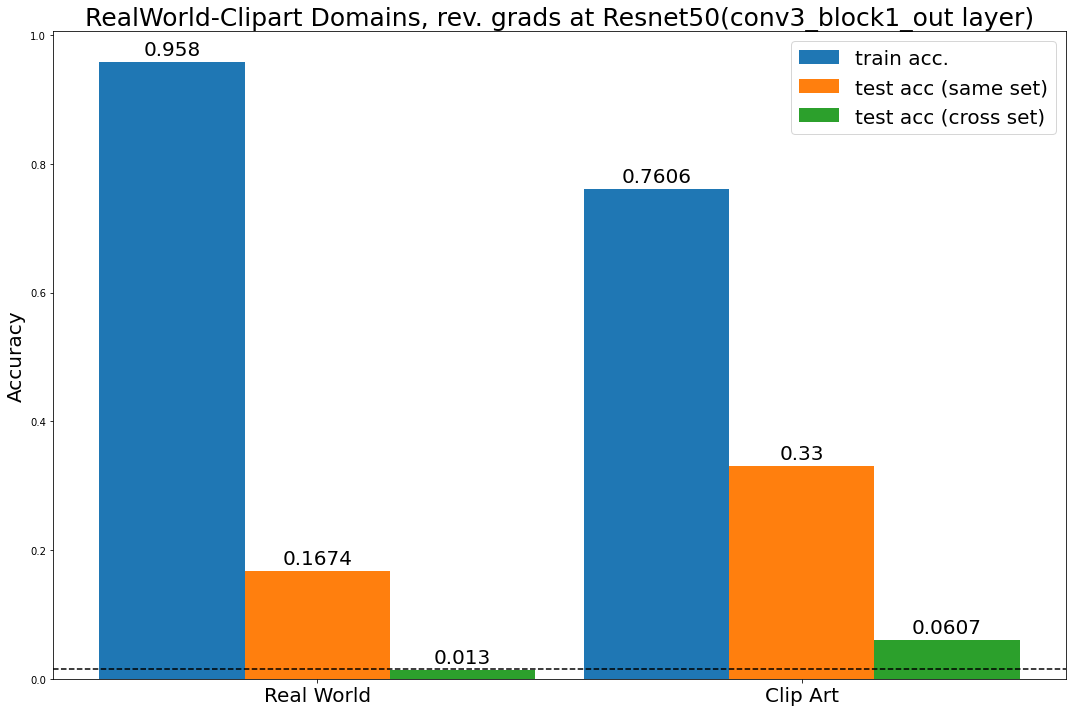

In [40]:
#plot details
plot_accuracies_3group([0.958, 0.7606], [0.1674, 0.33], [0.0130, 0.0607], 0.01538, ['Real World', 'Clip Art'], ['train acc.', 'test acc (same set)', 'test acc (cross set)'], "RealWorld-Clipart Domains, rev. grads at Resnet50(conv3_block1_out layer)")

$\bf \text{3. Applying gradient reversal at the Earlier layers: 'conv2_block2_1_bn' layer}$

$$MNIST \to USPS $$

In [9]:
my_model_mnist = Model_Resnet_DAN((28, 28, 3), 10)
my_model_mnist.make_DAN_Resnet('conv2_block2_1_bn', True)
my_model_mnist.train_RESNET_DAN(X_train_mnist, y_train_mnist, X_train_usps)

2022-10-28 10:59:16.896005: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-28 10:59:16.897050: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-28 10:59:16.940831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-10-28 10:59:16.941221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-10-28 10:59:16.941236: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.s

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, None, None, 3 0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add[0][0]             
____________________________________________________________________________

2022-10-28 10:59:18.729027: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-28 10:59:19.145195: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-10-28 10:59:19.191086: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-28 10:59:19.523723: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Losses at epoch 0,classification: 26.185344696044922 domain: 7.557199478149414, train Accuracies: classification: 0.109375 domain: 0.5
Losses at epoch 2,classification: 0.09254903346300125 domain: 7.712474346160889, train Accuracies: classification: 0.96875 domain: 0.5
Losses at epoch 4,classification: 0.03721361607313156 domain: 7.712474346160889, train Accuracies: classification: 0.9921875 domain: 0.5


({'loss_class': [26.185345, 0.116170645, 0.09254903, 0.051555358, 0.037213616],
  'loss_domain': [7.5571995, 7.7124743, 7.7124743, 7.7124743, 7.7124743]},
 {'acc_domain': [0.5, 0.5, 0.5, 0.5, 0.5],
  'acc_class': [0.109375, 0.9765625, 0.96875, 0.9921875, 0.9921875]})

In [10]:
accuracy_self_mnist = my_model_mnist.test_cross_generalization(X_test_mnist, y_test_mnist)
accuracy_cross_usps = my_model_mnist.test_cross_generalization(X_test_usps, y_test_usps)

2022-10-28 11:07:37.789823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-28 11:07:37.810907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492975000 Hz


63/63 [==============================] - 10s 160ms/step - loss: 0.0000e+00 - accuracy: 0.9193


$$USPS \to MNIST$$

In [12]:
my_model_usps = Model_Resnet_DAN((28, 28, 3), 10)
my_model_usps.make_DAN_Resnet('conv2_block3_1_bn', True)
my_model_usps.train_RESNET_DAN(X_train_usps, y_train_usps, X_train_mnist, 20)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_1[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_1[0][0]           
____________________________________________________________________________

Losses at epoch 2,classification: 0.31961387395858765 domain: 6.582810401916504, train Accuracies: classification: 0.8984375 domain: 0.5
Losses at epoch 4,classification: 0.09958676993846893 domain: 7.712474346160889, train Accuracies: classification: 0.9609375 domain: 0.5
Losses at epoch 6,classification: 0.01828763447701931 domain: 7.712474346160889, train Accuracies: classification: 1.0 domain: 0.5
Losses at epoch 8,classification: 0.008170566521584988 domain: 7.712474346160889, train Accuracies: classification: 1.0 domain: 0.5
Losses at epoch 10,classification: 0.022718986496329308 domain: 7.712474346160889, train Accuracies: classification: 0.9921875 domain: 0.5
Losses at epoch 12,classification: 0.07325424253940582 domain: 7.712474346160889, train Accuracies: classification: 0.9765625 domain: 0.5
Losses at epoch 14,classification: 0.0016961604123935103 domain: 7.712474346160889, train Accuracies: classification: 1.0 domain: 0.5
Losses at epoch 16,classification: 0.028068179264664

({'loss_class': [8.777425,
   0.79541945,
   0.31961387,
   0.122995555,
   0.09958677,
   0.13771665,
   0.018287634,
   0.015644807,
   0.0081705665,
   0.061655648,
   0.022718986,
   0.02246846,
   0.07325424,
   0.15446761,
   0.0016961604,
   0.055405017,
   0.02806818,
   0.05870372,
   0.007451345,
   0.083932415],
  'loss_domain': [5.719117,
   7.6666193,
   6.5828104,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743]},
 {'acc_domain': [0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5],
  'acc_class': [0.0859375,
   0.6875,
   0.8984375,
   0.953125,
   0.9609375,
   0.96875,
   1.0,
   1.0,
   1.0,
   0.9921875,
   0.9921875,
   0.9921875,
   0.9765625,
   0.96875,
   1.0,
   0.9765625,

In [13]:
accuracy_self_usps = my_model_usps.test_cross_generalization(X_test_usps, y_test_usps)
accuracy_cross_mnsit = my_model_usps.test_cross_generalization(X_test_mnist, y_test_mnist)

313/313 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - accuracy: 0.8101


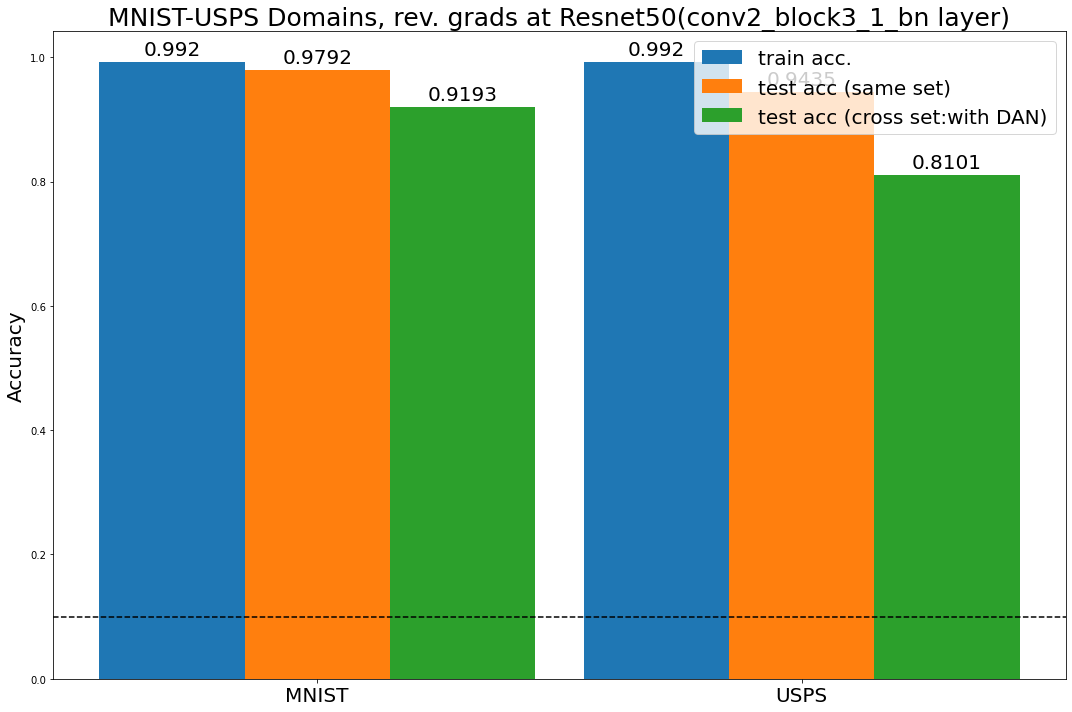

In [29]:
plot_accuracies_3group([0.992, 0.992], [0.9792, 0.9435], [0.9193, 0.8101], 0.1, ['MNIST', 'USPS'], ['train acc.', 'test acc (same set)', 'test acc (cross set:with DAN)'], "MNIST-USPS Domains, rev. grads at Resnet50(conv2_block3_1_bn layer)")

$$Clipart \to Real World$$

In [15]:
#number of unique labels is 65, 64 batch size and, last input is the lambda for DAN
my_model_clip = Model_Resnet_DAN((128, 128, 3), 65, 64, 0.1)
my_model_clip.make_DAN_Resnet('conv2_block3_1_bn', True)
my_model_clip.train_RESNET_DAN(X_train_clip, y_train_clip, X_train_real, 20)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_2[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_2[0][0]           
____________________________________________________________________________

Losses at epoch 0,classification: 20.3575439453125 domain: 3.5592212677001953, train Accuracies: classification: 0.0 domain: 0.5
Losses at epoch 2,classification: 3.9736742973327637 domain: 7.666619300842285, train Accuracies: classification: 0.078125 domain: 0.5
Losses at epoch 4,classification: 4.273420333862305 domain: 7.712474346160889, train Accuracies: classification: 0.03125 domain: 0.5
Losses at epoch 6,classification: 3.9631803035736084 domain: 7.712474346160889, train Accuracies: classification: 0.046875 domain: 0.5
Losses at epoch 8,classification: 3.6586413383483887 domain: 7.712474346160889, train Accuracies: classification: 0.109375 domain: 0.5
Losses at epoch 10,classification: 3.171962022781372 domain: 7.712474346160889, train Accuracies: classification: 0.203125 domain: 0.5
Losses at epoch 12,classification: 2.683175802230835 domain: 7.712474346160889, train Accuracies: classification: 0.359375 domain: 0.5
Losses at epoch 14,classification: 2.1249966621398926 domain: 7

({'loss_class': [20.357544,
   4.0793495,
   3.9736743,
   4.194478,
   4.2734203,
   4.0150356,
   3.9631803,
   3.811069,
   3.6586413,
   3.4751644,
   3.171962,
   3.3617468,
   2.6831758,
   2.1322083,
   2.1249967,
   1.5714281,
   1.3957446,
   1.693543,
   1.0955914,
   0.84054965],
  'loss_domain': [3.5592213,
   7.6666193,
   7.6666193,
   3.7801807,
   7.7124743,
   7.7124786,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743,
   7.7124743]},
 {'acc_domain': [0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5],
  'acc_class': [0.0,
   0.015625,
   0.078125,
   0.015625,
   0.03125,
   0.03125,
   0.046875,
   0.109375,
   0.109375,
   0.171875,
   0.203125,
   0.171875,
   0.359375,
   0.375,
   0.453125,
   0.609375,
   0.625,
   0.5625,
   0

In [16]:
accuracy_self_clip = my_model_clip.test_cross_generalization(X_test_clip, y_test_clip)
accuracy_cross_real = my_model_clip.test_cross_generalization(X_test_real, y_test_real)

27/27 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0496


In [ ]:
del my_model_clip

$$Real World \to Clipart$$

In [33]:
#number of unique labels is 65
my_model_real = Model_Resnet_DAN((128, 128, 3), 65, 64)
my_model_real.make_DAN_Resnet('conv2_block3_1_bn', True)
my_model_real.train_RESNET_DAN(X_train_real, y_train_real, X_train_clip, 40)

Model: "feature_extractor_label"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Resnet_input (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, None, None, 3 0           Resnet_input[0][0]               
__________________________________________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda)   (None, None, None, 3 0           tf.__operators__.getitem_4[0][0] 
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           tf.nn.bias_add_4[0][0]           
____________________________________________________________________________

Losses at epoch 2,classification: 3.9238860607147217 domain: 7.568153381347656, train Accuracies: classification: 0.109375 domain: 0.5
Losses at epoch 4,classification: 3.972836494445801 domain: 7.666619300842285, train Accuracies: classification: 0.0625 domain: 0.5
Losses at epoch 6,classification: 3.8841848373413086 domain: 7.666619300842285, train Accuracies: classification: 0.046875 domain: 0.5
Losses at epoch 8,classification: 3.6795949935913086 domain: 7.666619300842285, train Accuracies: classification: 0.078125 domain: 0.5
Losses at epoch 10,classification: 3.724356174468994 domain: 7.666619300842285, train Accuracies: classification: 0.109375 domain: 0.5
Losses at epoch 12,classification: 3.094554901123047 domain: 7.666619300842285, train Accuracies: classification: 0.234375 domain: 0.5
Losses at epoch 14,classification: 3.0234804153442383 domain: 7.666619300842285, train Accuracies: classification: 0.21875 domain: 0.5
Losses at epoch 16,classification: 2.7291855812072754 doma

({'loss_class': [18.792767,
   4.137396,
   3.923886,
   4.046779,
   3.9728365,
   3.842401,
   3.8841848,
   3.5919685,
   3.679595,
   3.6610272,
   3.7243562,
   3.4630678,
   3.094555,
   2.810366,
   3.0234804,
   2.8006449,
   2.7291856,
   2.3942878,
   2.0897639,
   2.2577486,
   1.7708136,
   1.4530125,
   1.5441105,
   1.0522505,
   0.9026462,
   0.8369191,
   0.73720014,
   0.84638786,
   0.38336268,
   0.46215752,
   0.3296103,
   0.5385007,
   0.12576936,
   0.17210142,
   0.21483384,
   0.18920347,
   0.08087188,
   0.12748098,
   0.1358764,
   0.027318846],
  'loss_domain': [2.3914168,
   7.70969,
   7.5681534,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
   7.6666193,
 

In [34]:
accuracy_self_real = my_model_real.test_cross_generalization(X_test_real, y_test_real)
accuracy_cross_clip = my_model_real.test_cross_generalization(X_test_clip, y_test_clip)

27/27 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0650


In [ ]:
del my_model_real

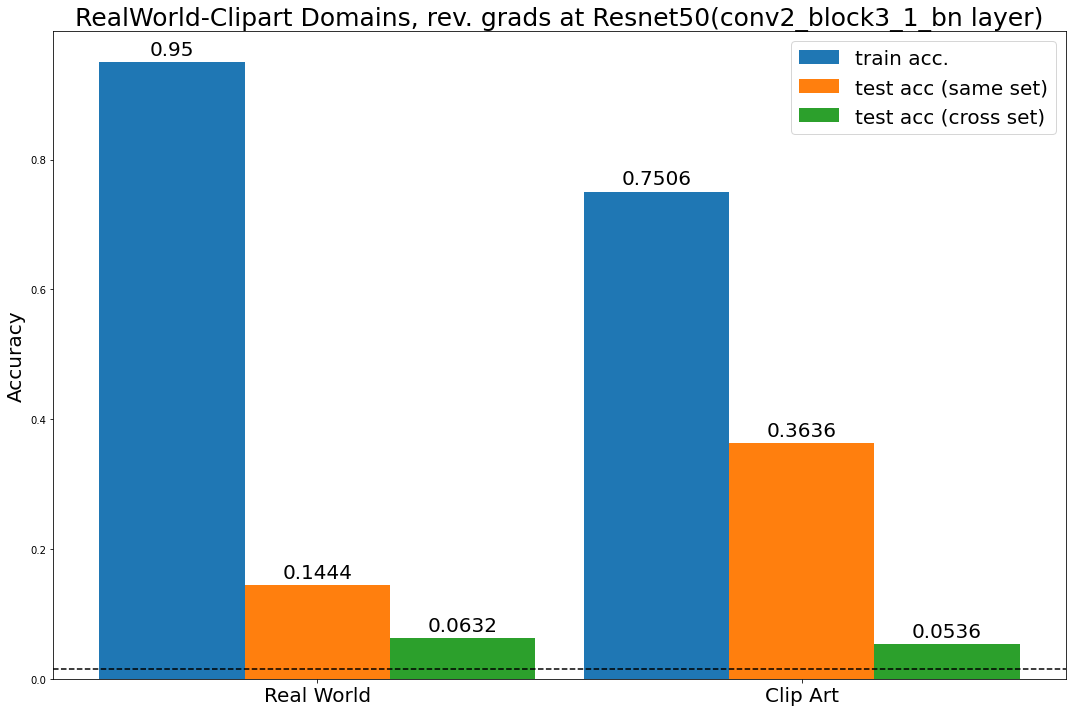

In [36]:
#plot details
plot_accuracies_3group([0.95, 0.7506], [0.1444, 0.3636], [0.0632, 0.0536], 0.01538, ['Real World', 'Clip Art'], ['train acc.', 'test acc (same set)', 'test acc (cross set)'], "RealWorld-Clipart Domains, rev. grads at Resnet50(conv2_block3_1_bn layer)")